## 1. Import Libraries và Cấu hình

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Visualization
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data')
FEATURES_DIR = DATA_DIR / 'features'
CLUSTERS_DIR = DATA_DIR / 'clusters'
CLUSTERS_DIR.mkdir(exist_ok=True)

# Clustering parameters
K_RANGE = range(2, 13)  # Test K from 2 to 12
RANDOM_STATE = 42

print(f"✓ Libraries imported")
print(f"✓ Data directory: {DATA_DIR}")
print(f"✓ Testing K values: {list(K_RANGE)}")

✓ Libraries imported
✓ Data directory: ..\data
✓ Testing K values: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


## 2. Load Feature Variants

In [2]:
# Load configuration
with open(FEATURES_DIR / 'feature_variants_config.json', 'r') as f:
    variants_config = json.load(f)

# Load all feature variants
feature_variants = {}
for variant_name in variants_config.keys():
    file_path = FEATURES_DIR / f"{variant_name}.csv"
    df = pd.read_csv(file_path, index_col=0)
    feature_variants[variant_name] = df
    print(f"✓ Loaded {variant_name}: {df.shape}")

print(f"\n✓ Total variants loaded: {len(feature_variants)}")

✓ Loaded baseline_binary: (3921, 175)
✓ Loaded variant_a_weighted: (3921, 175)
✓ Loaded variant_b_binary_rfm: (3921, 178)
✓ Loaded variant_c_weighted_rfm: (3921, 178)

✓ Total variants loaded: 4


## 3. Khảo Sát K với Multiple Metrics

### 3.1 Define Evaluation Functions

In [3]:
def evaluate_k_range(features: pd.DataFrame, k_range: range, random_state: int = 42) -> Dict:
    """
    Evaluate clustering performance across different K values.
    
    Returns:
        Dictionary with metrics: inertia, silhouette, davies_bouldin, calinski_harabasz
    """
    results = {
        'k_values': [],
        'inertia': [],  # For Elbow method (lower is better)
        'silhouette': [],  # Higher is better [-1, 1]
        'davies_bouldin': [],  # Lower is better
        'calinski_harabasz': []  # Higher is better
    }
    
    features_array = features.values
    
    for k in k_range:
        # Train K-Means
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(features_array)
        
        # Calculate metrics
        results['k_values'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(features_array, labels))
        results['davies_bouldin'].append(davies_bouldin_score(features_array, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(features_array, labels))
    
    return results

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 3.2 Run Evaluation for All Variants

In [4]:
evaluation_results = {}

for variant_name, features_df in feature_variants.items():
    print(f"\nEvaluating {variant_name}...")
    results = evaluate_k_range(features_df, K_RANGE, RANDOM_STATE)
    evaluation_results[variant_name] = results
    print(f"  ✓ Completed evaluation for K={K_RANGE[0]} to K={K_RANGE[-1]}")

print(f"\n✓ All variants evaluated")


Evaluating baseline_binary...
  ✓ Completed evaluation for K=2 to K=12

Evaluating variant_a_weighted...
  ✓ Completed evaluation for K=2 to K=12

Evaluating variant_b_binary_rfm...
  ✓ Completed evaluation for K=2 to K=12

Evaluating variant_c_weighted_rfm...
  ✓ Completed evaluation for K=2 to K=12

✓ All variants evaluated


## 4. Visualize Metrics for K Selection

### 4.1 Plot All Metrics for Each Variant

In [5]:
def plot_k_metrics(evaluation_results: Dict, variant_name: str):
    """
    Plot all 4 metrics for a single variant to help choose optimal K.
    """
    results = evaluation_results[variant_name]
    k_values = results['k_values']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'K Selection Metrics - {variant_name}', fontsize=14, fontweight='bold')
    
    # 1. Elbow Method (Inertia)
    ax1 = axes[0, 0]
    ax1.plot(k_values, results['inertia'], 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Inertia (within-cluster sum of squares)')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(k_values)
    
    # 2. Silhouette Score (higher is better)
    ax2 = axes[0, 1]
    ax2.plot(k_values, results['silhouette'], 'o-', color='green', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score (Higher is Better)')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(k_values)
    # Mark best K
    best_k_sil = k_values[np.argmax(results['silhouette'])]
    ax2.axvline(x=best_k_sil, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k_sil}')
    ax2.legend()
    
    # 3. Davies-Bouldin Index (lower is better)
    ax3 = axes[1, 0]
    ax3.plot(k_values, results['davies_bouldin'], 'o-', color='orange', linewidth=2, markersize=8)
    ax3.set_xlabel('Number of Clusters (K)')
    ax3.set_ylabel('Davies-Bouldin Index')
    ax3.set_title('Davies-Bouldin Index (Lower is Better)')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(k_values)
    # Mark best K
    best_k_db = k_values[np.argmin(results['davies_bouldin'])]
    ax3.axvline(x=best_k_db, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k_db}')
    ax3.legend()
    
    # 4. Calinski-Harabasz Score (higher is better)
    ax4 = axes[1, 1]
    ax4.plot(k_values, results['calinski_harabasz'], 'o-', color='purple', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Clusters (K)')
    ax4.set_ylabel('Calinski-Harabasz Score')
    ax4.set_title('Calinski-Harabasz Score (Higher is Better)')
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(k_values)
    # Mark best K
    best_k_ch = k_values[np.argmax(results['calinski_harabasz'])]
    ax4.axvline(x=best_k_ch, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k_ch}')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_k_sil, best_k_db, best_k_ch

print("✓ Visualization function defined")

✓ Visualization function defined


### 4.2 Generate Plots for Each Variant


VARIANT: baseline_binary


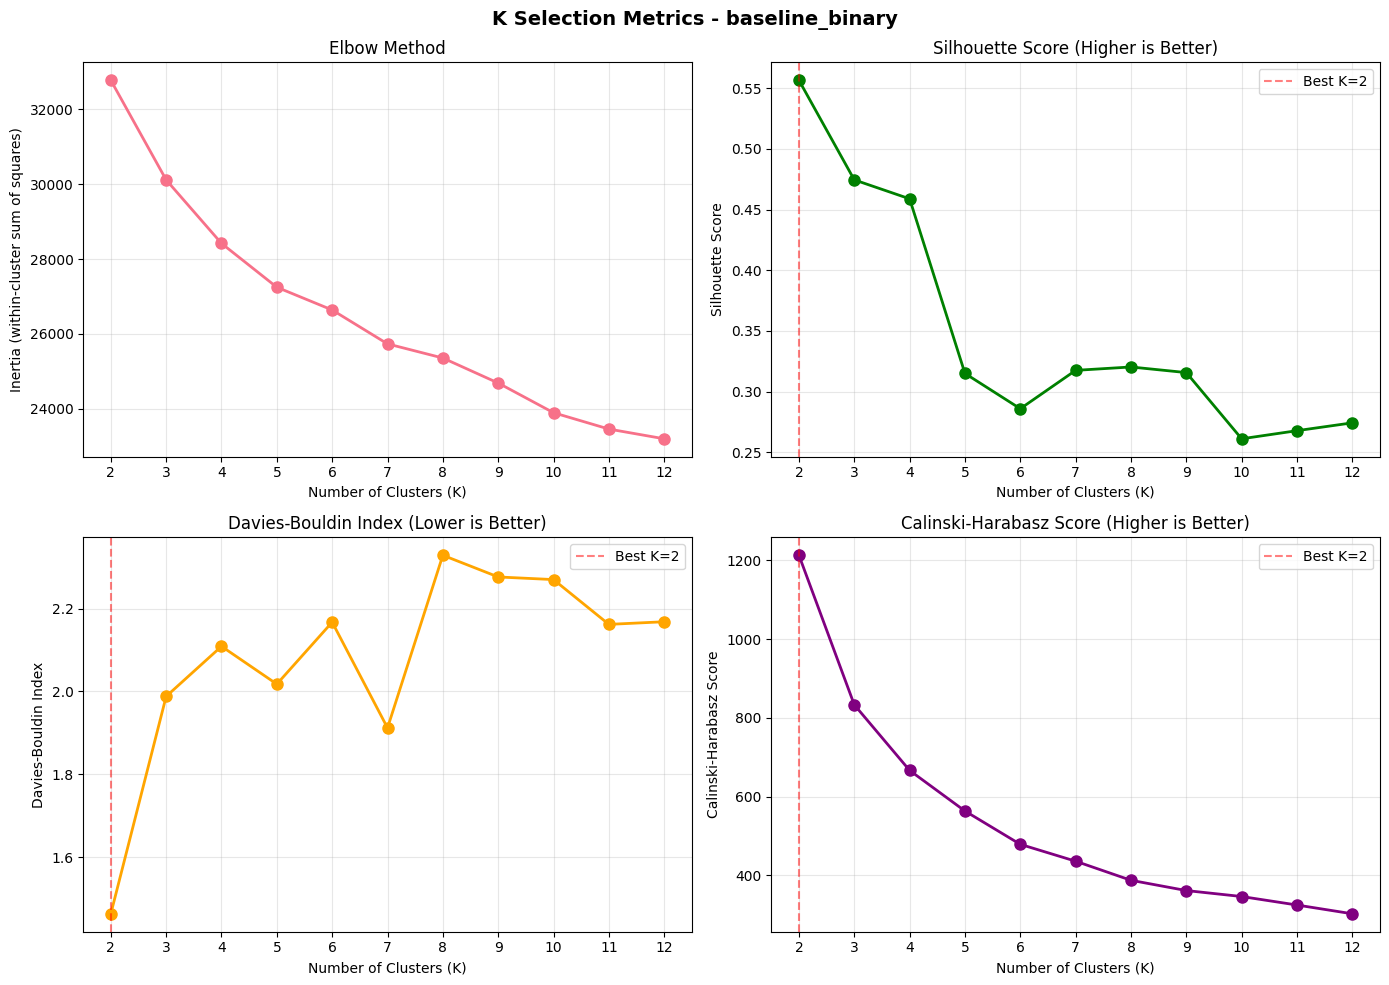


Best K recommendations:
  - Silhouette Score: K=2
  - Davies-Bouldin: K=2
  - Calinski-Harabasz: K=2

VARIANT: variant_a_weighted


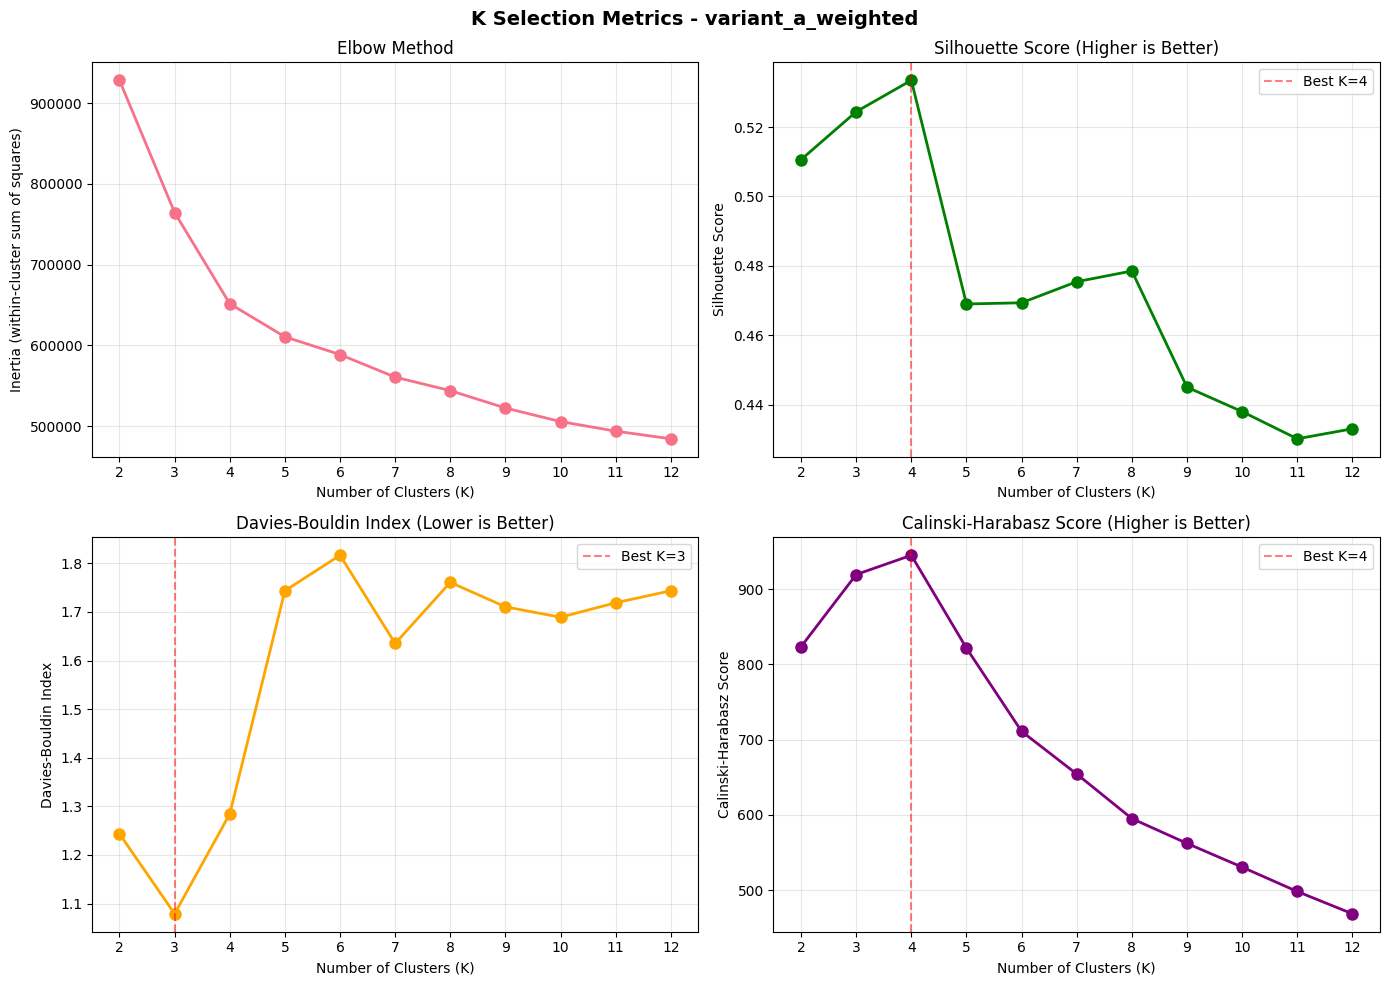


Best K recommendations:
  - Silhouette Score: K=4
  - Davies-Bouldin: K=3
  - Calinski-Harabasz: K=4

VARIANT: variant_b_binary_rfm


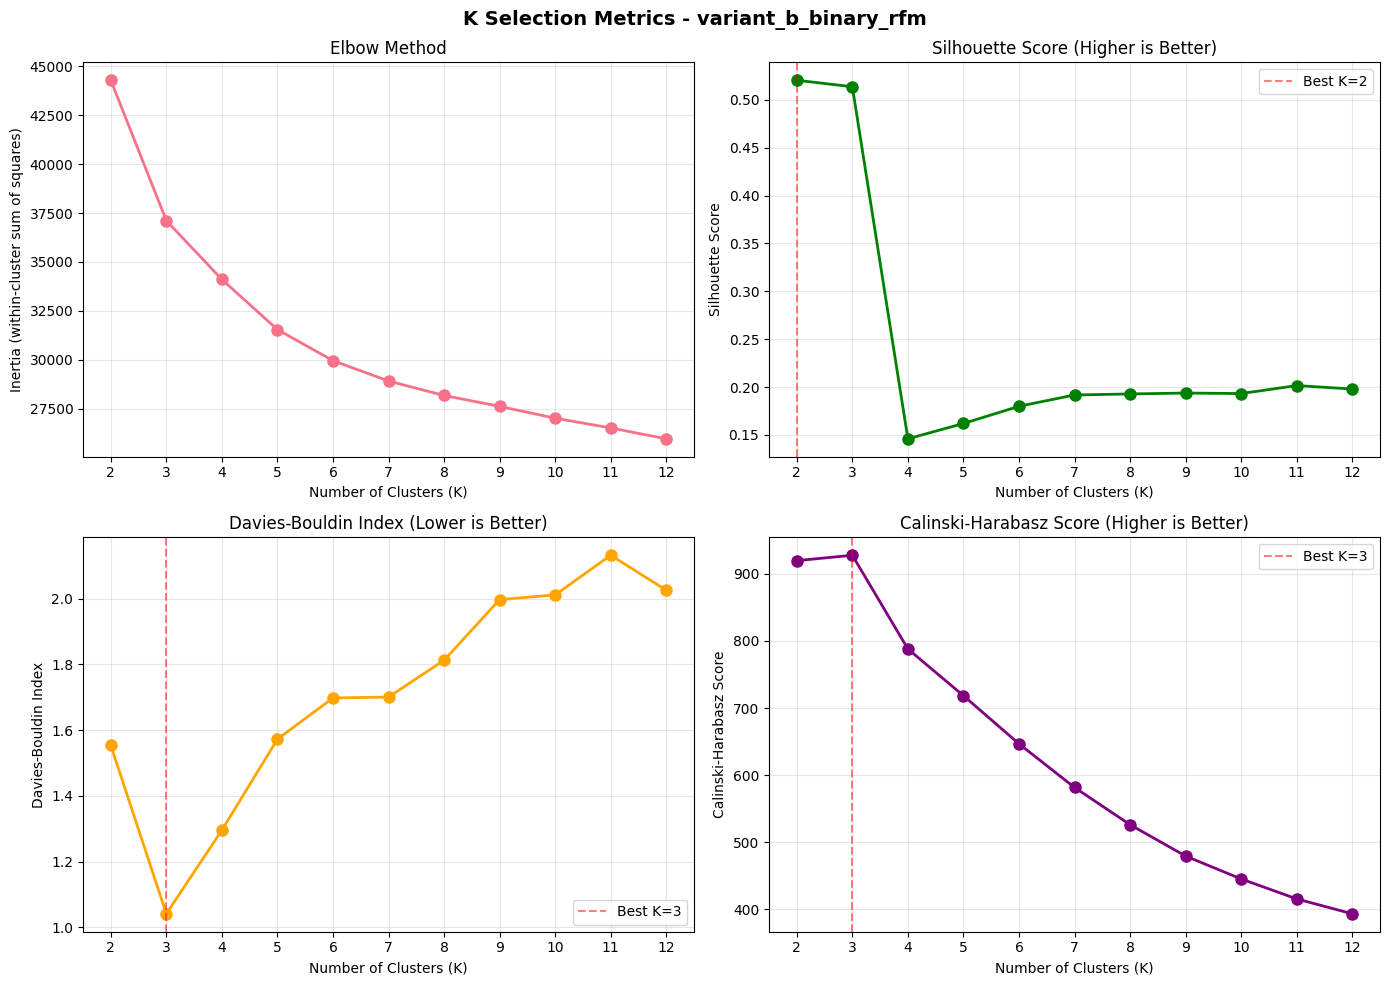


Best K recommendations:
  - Silhouette Score: K=2
  - Davies-Bouldin: K=3
  - Calinski-Harabasz: K=3

VARIANT: variant_c_weighted_rfm


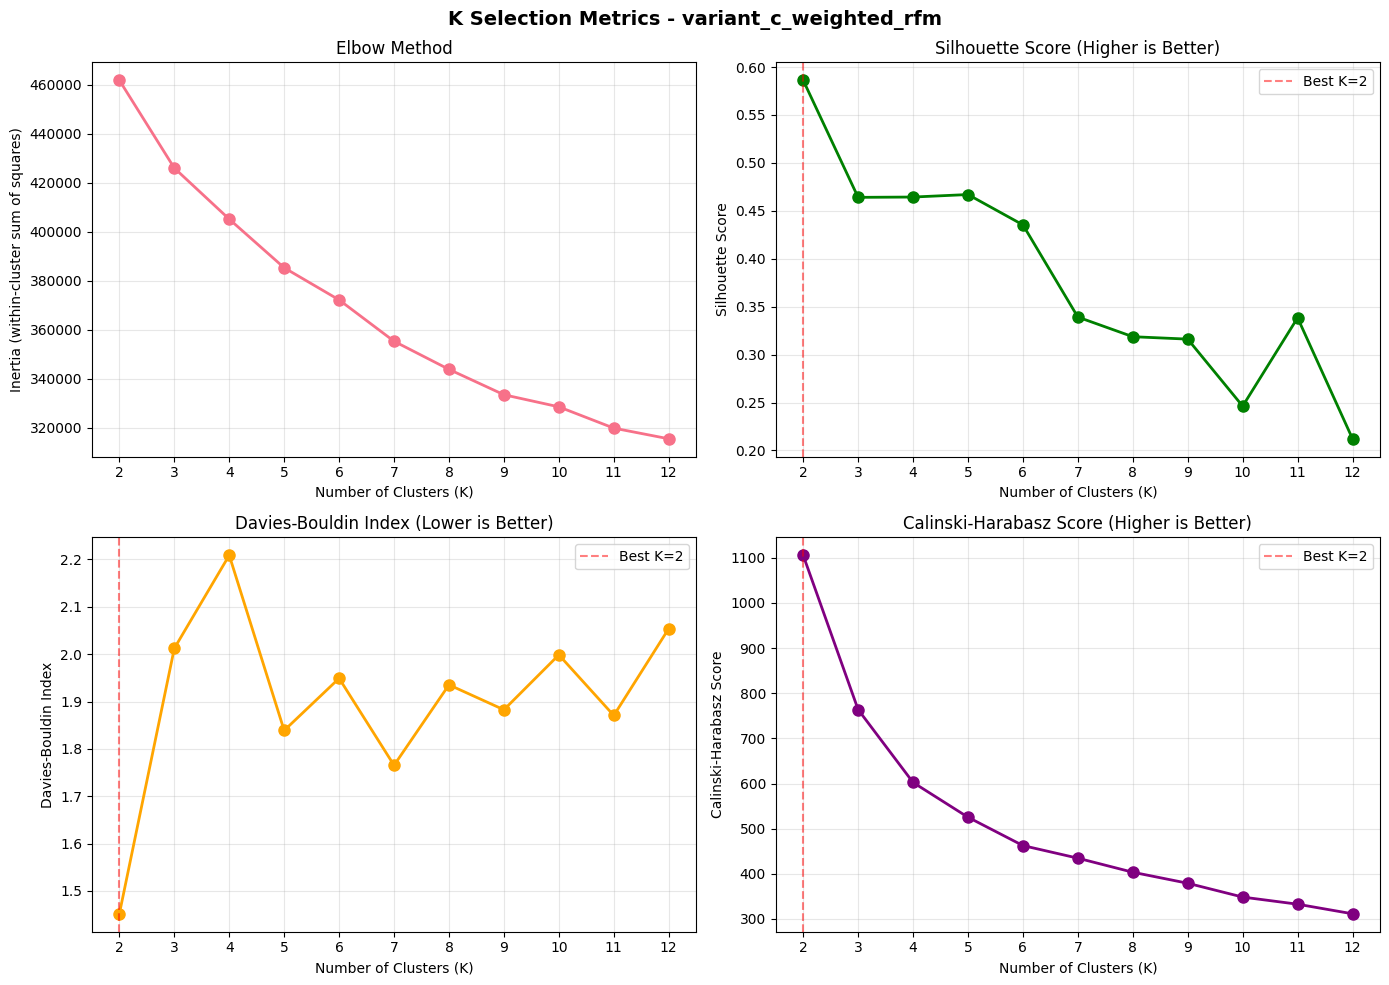


Best K recommendations:
  - Silhouette Score: K=2
  - Davies-Bouldin: K=2
  - Calinski-Harabasz: K=2


In [6]:
best_k_recommendations = {}

for variant_name in evaluation_results.keys():
    print(f"\n{'='*80}")
    print(f"VARIANT: {variant_name}")
    print(f"{'='*80}")
    
    best_k_sil, best_k_db, best_k_ch = plot_k_metrics(evaluation_results, variant_name)
    
    best_k_recommendations[variant_name] = {
        'silhouette': best_k_sil,
        'davies_bouldin': best_k_db,
        'calinski_harabasz': best_k_ch
    }
    
    print(f"\nBest K recommendations:")
    print(f"  - Silhouette Score: K={best_k_sil}")
    print(f"  - Davies-Bouldin: K={best_k_db}")
    print(f"  - Calinski-Harabasz: K={best_k_ch}")

## 5. Tổng Hợp Metrics và Lựa Chọn K Tối Ưu

### 5.1 Create Metrics Summary Table

In [7]:
def create_metrics_summary(evaluation_results: Dict) -> pd.DataFrame:
    """
    Create a comprehensive summary table of all metrics for all variants.
    """
    summary_data = []
    
    for variant_name, results in evaluation_results.items():
        k_values = results['k_values']
        
        for i, k in enumerate(k_values):
            summary_data.append({
                'Variant': variant_name,
                'K': k,
                'Inertia': results['inertia'][i],
                'Silhouette': results['silhouette'][i],
                'Davies_Bouldin': results['davies_bouldin'][i],
                'Calinski_Harabasz': results['calinski_harabasz'][i]
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

metrics_summary = create_metrics_summary(evaluation_results)

print("\n" + "="*80)
print("METRICS SUMMARY FOR ALL VARIANTS")
print("="*80)
print(metrics_summary.to_string(index=False))


METRICS SUMMARY FOR ALL VARIANTS
               Variant  K       Inertia  Silhouette  Davies_Bouldin  Calinski_Harabasz
       baseline_binary  2  32777.506623    0.556582        1.462913        1213.058686
       baseline_binary  3  30114.645701    0.474515        1.987971         833.215555
       baseline_binary  4  28417.043181    0.458897        2.108934         666.509444
       baseline_binary  5  27245.463194    0.315028        2.017638         563.342267
       baseline_binary  6  26637.454298    0.285955        2.167285         478.715123
       baseline_binary  7  25731.459039    0.317559        1.911904         435.838356
       baseline_binary  8  25353.356587    0.320346        2.328863         387.386655
       baseline_binary  9  24684.978974    0.315718        2.276442         361.292526
       baseline_binary 10  23891.545661    0.261168        2.270129         346.160882
       baseline_binary 11  23454.531563    0.267856        2.161928         324.553743
       ba

### 5.2 Analyze and Select Optimal K for Each Variant

In [8]:
def select_optimal_k(results: Dict, variant_name: str) -> Tuple[int, str]:
    """
    Select optimal K considering all metrics and marketing actionability.
    
    Returns:
        (optimal_k, justification_text)
    """
    k_values = results['k_values']
    
    # Find best K for each metric
    best_k_silhouette = k_values[np.argmax(results['silhouette'])]
    best_k_db = k_values[np.argmin(results['davies_bouldin'])]
    best_k_ch = k_values[np.argmax(results['calinski_harabasz'])]
    
    # Get metric values for analysis
    silhouette_scores = results['silhouette']
    inertia_values = results['inertia']
    
    # Calculate elbow point (rate of change in inertia)
    inertia_diff = np.diff(inertia_values)
    inertia_diff_rate = np.diff(inertia_diff)
    
    # Voting mechanism: find most common best K
    votes = [best_k_silhouette, best_k_db, best_k_ch]
    from collections import Counter
    vote_counts = Counter(votes)
    most_voted_k = vote_counts.most_common(1)[0][0]
    
    # Consider marketing actionability: 
    # Too few clusters (K<3) - not enough granularity
    # Too many clusters (K>8) - hard to manage marketing campaigns
    
    if most_voted_k < 3:
        # If voted K is too small, choose K=3 or K=4
        optimal_k = 3 if 3 in k_values else 4
        justification = f"Metrics suggest K={most_voted_k}, but for marketing actionability, K={optimal_k} provides better segment granularity."
    elif most_voted_k > 8:
        # If voted K is too large, cap at K=6 or K=7
        optimal_k = min(most_voted_k, 7)
        justification = f"Metrics suggest K={most_voted_k}, but K={optimal_k} offers better manageability for marketing campaigns."
    else:
        optimal_k = most_voted_k
        justification = f"K={optimal_k} shows consensus across metrics (Silhouette={best_k_silhouette}, DB={best_k_db}, CH={best_k_ch}) and aligns with marketing actionability."
    
    # Add specific metric values
    k_idx = k_values.index(optimal_k)
    justification += f" At K={optimal_k}: Silhouette={silhouette_scores[k_idx]:.4f}, provides meaningful customer segments for targeted marketing."
    
    return optimal_k, justification

# Select optimal K for each variant
optimal_k_choices = {}

print("\n" + "="*80)
print("OPTIMAL K SELECTION WITH JUSTIFICATION")
print("="*80)

for variant_name, results in evaluation_results.items():
    optimal_k, justification = select_optimal_k(results, variant_name)
    optimal_k_choices[variant_name] = {
        'optimal_k': optimal_k,
        'justification': justification
    }
    
    print(f"\n{variant_name}:")
    print(f"  Optimal K: {optimal_k}")
    print(f"  Justification: {justification}")


OPTIMAL K SELECTION WITH JUSTIFICATION

baseline_binary:
  Optimal K: 3
  Justification: Metrics suggest K=2, but for marketing actionability, K=3 provides better segment granularity. At K=3: Silhouette=0.4745, provides meaningful customer segments for targeted marketing.

variant_a_weighted:
  Optimal K: 4
  Justification: K=4 shows consensus across metrics (Silhouette=4, DB=3, CH=4) and aligns with marketing actionability. At K=4: Silhouette=0.5335, provides meaningful customer segments for targeted marketing.

variant_b_binary_rfm:
  Optimal K: 3
  Justification: K=3 shows consensus across metrics (Silhouette=2, DB=3, CH=3) and aligns with marketing actionability. At K=3: Silhouette=0.5137, provides meaningful customer segments for targeted marketing.

variant_c_weighted_rfm:
  Optimal K: 3
  Justification: Metrics suggest K=2, but for marketing actionability, K=3 provides better segment granularity. At K=3: Silhouette=0.4640, provides meaningful customer segments for targeted mark

## 6. Train Final K-Means Models

### 6.1 Train Models with Optimal K

In [9]:
final_models = {}
cluster_assignments = {}

print("\n" + "="*80)
print("TRAINING FINAL K-MEANS MODELS")
print("="*80)

for variant_name, features_df in feature_variants.items():
    optimal_k = optimal_k_choices[variant_name]['optimal_k']
    
    print(f"\n{variant_name}: Training with K={optimal_k}...")
    
    # Train final model
    kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(features_df.values)
    
    # Store model and labels
    final_models[variant_name] = kmeans
    
    # Create DataFrame with cluster assignments
    cluster_df = pd.DataFrame({
        'CustomerID': features_df.index,
        'Cluster': labels
    })
    cluster_assignments[variant_name] = cluster_df
    
    # Print cluster distribution
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    print(f"  Cluster distribution:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(labels)) * 100
        print(f"    Cluster {cluster_id}: {count} customers ({percentage:.2f}%)")
    
    # Calculate final metrics
    silhouette = silhouette_score(features_df.values, labels)
    davies_bouldin = davies_bouldin_score(features_df.values, labels)
    calinski_harabasz = calinski_harabasz_score(features_df.values, labels)
    
    print(f"  Final metrics:")
    print(f"    Silhouette Score: {silhouette:.4f}")
    print(f"    Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"    Calinski-Harabasz Score: {calinski_harabasz:.2f}")
    print(f"  ✓ Model trained and stored")

print(f"\n✓ All final models trained successfully")


TRAINING FINAL K-MEANS MODELS

baseline_binary: Training with K=3...
  Cluster distribution:
    Cluster 0: 3304 customers (84.26%)
    Cluster 1: 225 customers (5.74%)
    Cluster 2: 392 customers (10.00%)
  Final metrics:
    Silhouette Score: 0.4739
    Davies-Bouldin Index: 1.9897
    Calinski-Harabasz Score: 833.22
  ✓ Model trained and stored

variant_a_weighted: Training with K=4...
  Cluster distribution:
    Cluster 0: 3132 customers (79.88%)
    Cluster 1: 242 customers (6.17%)
    Cluster 2: 199 customers (5.08%)
    Cluster 3: 348 customers (8.88%)
  Final metrics:
    Silhouette Score: 0.5335
    Davies-Bouldin Index: 1.2844
    Calinski-Harabasz Score: 945.02
  ✓ Model trained and stored

variant_b_binary_rfm: Training with K=3...
  Cluster distribution:
    Cluster 0: 3479 customers (88.73%)
    Cluster 1: 441 customers (11.25%)
    Cluster 2: 1 customers (0.03%)
  Final metrics:
    Silhouette Score: 0.5137
    Davies-Bouldin Index: 1.0410
    Calinski-Harabasz Score: 

## 7. Save Cluster Assignments

### 7.1 Export Cluster Labels to CSV

In [10]:
print("\n" + "="*80)
print("SAVING CLUSTER ASSIGNMENTS")
print("="*80)

for variant_name, cluster_df in cluster_assignments.items():
    output_path = CLUSTERS_DIR / f"clusters_{variant_name}.csv"
    cluster_df.to_csv(output_path, index=False)
    print(f"✓ Saved {variant_name}: {output_path}")

# Save optimal K choices and justifications
k_selection_summary = []
for variant_name, choice in optimal_k_choices.items():
    k_selection_summary.append({
        'Variant': variant_name,
        'Optimal_K': choice['optimal_k'],
        'Justification': choice['justification']
    })

k_summary_df = pd.DataFrame(k_selection_summary)
k_summary_path = CLUSTERS_DIR / 'optimal_k_summary.csv'
k_summary_df.to_csv(k_summary_path, index=False)
print(f"\n✓ Saved K selection summary: {k_summary_path}")

# Save detailed metrics
metrics_path = CLUSTERS_DIR / 'clustering_metrics_all.csv'
metrics_summary.to_csv(metrics_path, index=False)
print(f"✓ Saved detailed metrics: {metrics_path}")

print(f"\n✓ All clustering results saved to: {CLUSTERS_DIR}")


SAVING CLUSTER ASSIGNMENTS
✓ Saved baseline_binary: ..\data\clusters\clusters_baseline_binary.csv
✓ Saved variant_a_weighted: ..\data\clusters\clusters_variant_a_weighted.csv
✓ Saved variant_b_binary_rfm: ..\data\clusters\clusters_variant_b_binary_rfm.csv
✓ Saved variant_c_weighted_rfm: ..\data\clusters\clusters_variant_c_weighted_rfm.csv

✓ Saved K selection summary: ..\data\clusters\optimal_k_summary.csv
✓ Saved detailed metrics: ..\data\clusters\clustering_metrics_all.csv

✓ All clustering results saved to: ..\data\clusters


## 8. Visualize Final Cluster Assignments

### 8.1 PCA Visualization of Clusters


Visualizing baseline_binary with K=3


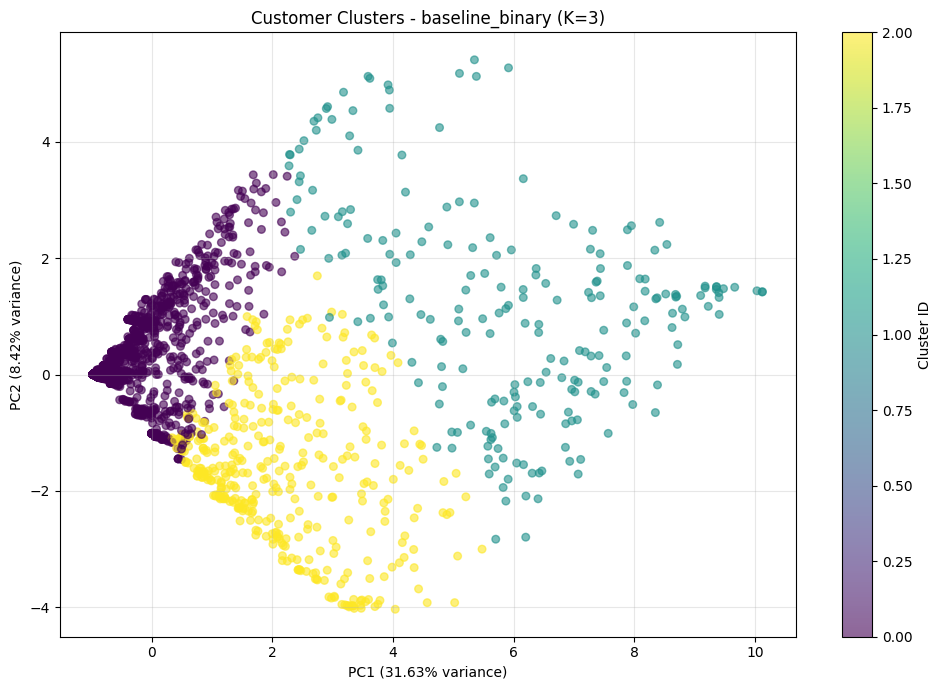


Visualizing variant_a_weighted with K=4


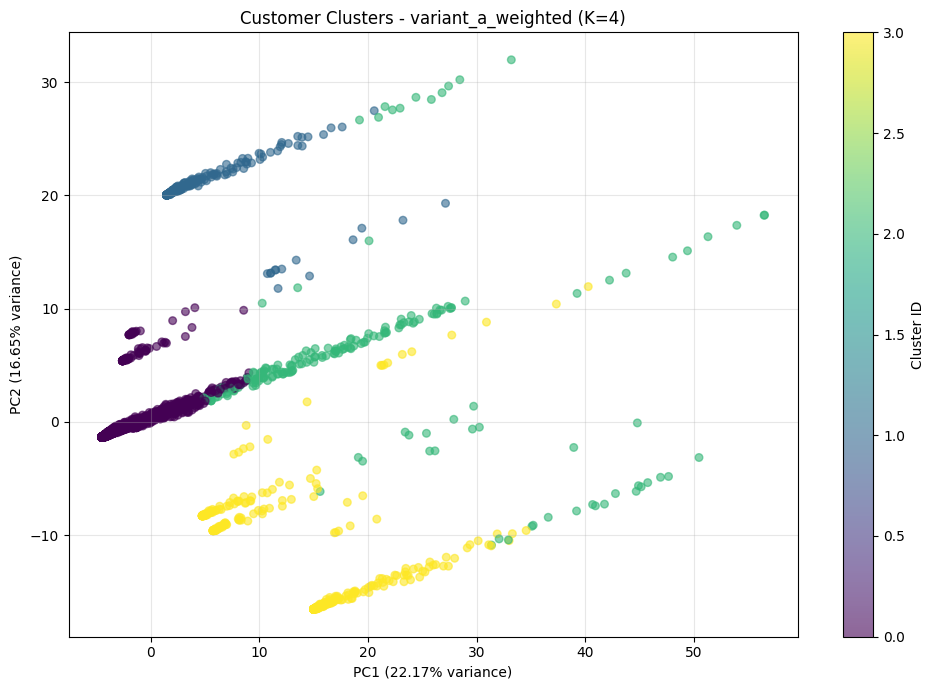


Visualizing variant_b_binary_rfm with K=3


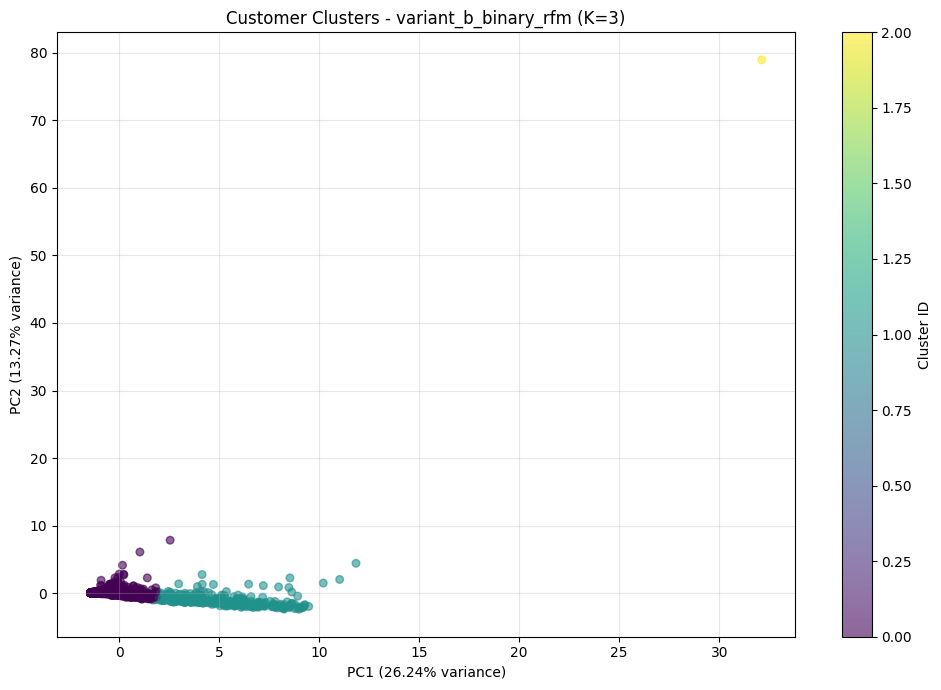


Visualizing variant_c_weighted_rfm with K=3


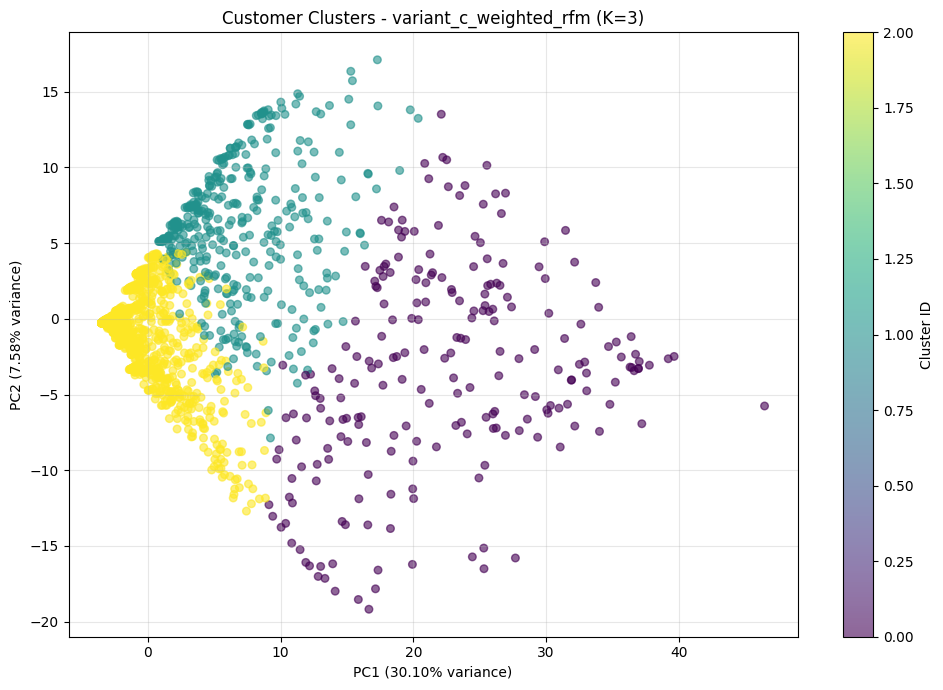

In [11]:
from sklearn.decomposition import PCA

def visualize_clusters_pca(features_df: pd.DataFrame, labels: np.ndarray, variant_name: str, optimal_k: int):
    """
    Visualize clusters using PCA dimensionality reduction.
    """
    # Apply PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    features_pca = pca.fit_transform(features_df.values)
    
    # Create plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                         c=labels, cmap='viridis', alpha=0.6, s=30)
    plt.colorbar(scatter, label='Cluster ID')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'Customer Clusters - {variant_name} (K={optimal_k})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate visualizations for each variant
for variant_name, features_df in feature_variants.items():
    optimal_k = optimal_k_choices[variant_name]['optimal_k']
    labels = cluster_assignments[variant_name]['Cluster'].values
    
    print(f"\nVisualizing {variant_name} with K={optimal_k}")
    visualize_clusters_pca(features_df, labels, variant_name, optimal_k)

## 9. Summary và Next Steps

In [12]:
print("\n" + "="*80)
print("CLUSTERING PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)

print("\n📊 Summary of Results:")
print(f"\n1. Feature Variants Analyzed: {len(feature_variants)}")
for variant_name in feature_variants.keys():
    print(f"   - {variant_name}")

print(f"\n2. K Range Evaluated: {K_RANGE[0]} to {K_RANGE[-1]}")

print(f"\n3. Optimal K Selected:")
for variant_name, choice in optimal_k_choices.items():
    print(f"   - {variant_name}: K={choice['optimal_k']}")

print(f"\n4. Files Saved:")
print(f"   - Cluster assignments: {CLUSTERS_DIR}/clusters_*.csv")
print(f"   - K selection summary: {CLUSTERS_DIR}/optimal_k_summary.csv")
print(f"   - Detailed metrics: {CLUSTERS_DIR}/clustering_metrics_all.csv")

print(f"\n5. Next Steps:")
print(f"   - Analyze cluster characteristics and profiles")
print(f"   - Map clusters to RFM segments for business interpretation")
print(f"   - Develop targeted marketing strategies per cluster")
print(f"   - Validate clusters with business stakeholders")

print(f"\n✓ Ready for cluster profiling and marketing strategy development!")


CLUSTERING PIPELINE COMPLETED SUCCESSFULLY

📊 Summary of Results:

1. Feature Variants Analyzed: 4
   - baseline_binary
   - variant_a_weighted
   - variant_b_binary_rfm
   - variant_c_weighted_rfm

2. K Range Evaluated: 2 to 12

3. Optimal K Selected:
   - baseline_binary: K=3
   - variant_a_weighted: K=4
   - variant_b_binary_rfm: K=3
   - variant_c_weighted_rfm: K=3

4. Files Saved:
   - Cluster assignments: ..\data\clusters/clusters_*.csv
   - K selection summary: ..\data\clusters/optimal_k_summary.csv
   - Detailed metrics: ..\data\clusters/clustering_metrics_all.csv

5. Next Steps:
   - Analyze cluster characteristics and profiles
   - Map clusters to RFM segments for business interpretation
   - Develop targeted marketing strategies per cluster
   - Validate clusters with business stakeholders

✓ Ready for cluster profiling and marketing strategy development!
